In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy 
import scipy as sp

from scipy import stats,signal
import statsmodels.api as sm
import math

from scipy.fft import fft, ifft 

from scipy.signal import medfilt

from transforms3d.axangles import axangle2mat


col = ['X','Y', 'Z']

In [13]:
# import the median filter function
# return the med-filtered signal: numpy array 1D
def median_filter(signal):       # input: numpy array 1D (one column)
    array=np.array(signal) 
    
    #applying the median filter
    med_filtered=scipy.signal.medfilt(array, kernel_size=3) # applying the median filter order3(kernel_size=3)
    return  med_filtered 


## Low-path Butterworth Filter
def butter_lowpass(cutoff, nyq_freq, order): ##CORRECT
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order): ##CORRECT
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data) 
    return y



## Derivative
def jerk_one_signal(signal):
    dt=0.02 # dt=1/50=0.02s time duration between two rows
    return np.array([(signal[i+1]-signal[i])/dt for i in range(len(signal)-1)])
#     return signal.diff()


### Magnitude
def mag(df):
    result = []
    for i in range(df.shape[0]):
        x, y, z = df.iloc[i,:].values
        mag = np.sqrt(x**2 + y**2 + z**2)
        result.append(mag)
    return result


## FFT
from scipy import fftpack # import fftpack to use all fft functions
from numpy.fft import *

##################### fast_fourier_transform_one_signal #################
# Inputs: time signal 1D array
# Output: amplitude of fft components 1D array having the same lenght as the Input
def fast_fourier_transform_one_signal(t_signal):
    # apply fast fourrier transform to the t_signal
    complex_f_signal= fftpack.fft(t_signal)
    #compute the amplitude each complex number
    amplitude_f_signal=np.abs(complex_f_signal)
    # return the amplitude
    return amplitude_f_signal

In [14]:
#     for i in col:
#         _,_,tBodyGyro[i],_ = components_selection_one_signal(med_gryo[i])
#         _, tGravityAcc[i], tBodyAcc[i],_= components_selection_one_signal(base_ac) 

In [15]:
def main(acc, gryo):
    
    med_gryo = pd.DataFrame(columns=col)
    med_acc = pd.DataFrame(columns=col)
    for i in col:
        med_gryo[i] = median_filter(gryo[i])
        med_acc[i] = median_filter(acc[i])
        
     
    ##############################################################
    #Butterworth Filter
    ##############################################################
    
    sample_rate = 50                    # 50Hz
    signal_length = 2.56 * sample_rate  # 2.56 seconds
    freq_20 = 20.0                      # 20Hz
    freq_03 = 0.3                       # 0.3HZ
    nyq_freq = sample_rate / 2          # 25Hz
    
    
    tGyro = pd.DataFrame(columns=col)
    tAcc = pd.DataFrame(columns=col)

    for i in col:
        tGyro[i] = butter_lowpass_filter(med_gryo[i], freq_20, nyq_freq, 3)
        tAcc[i] = butter_lowpass_filter(med_acc[i], freq_20, nyq_freq, 3)

    tBodyGyro = tGyro

    tGravityAcc = pd.DataFrame(columns=col)
    tBodyAcc = pd.DataFrame(columns=col)

    for i in col:
        tGravityAcc[i] = butter_lowpass_filter(tAcc[i], 0.3, nyq_freq, 1)
        tBodyAcc[i] = tAcc[i] - tGravityAcc[i] 



    
    tBodyAccJerk = pd.DataFrame(columns=col)
    tBodyGyroJerk = pd.DataFrame(columns=col)


    for i in col:
        #Derivative
        tBodyAccJerk[i] = jerk_one_signal(tBodyAcc[i])
        tBodyGyroJerk[i] = jerk_one_signal(tBodyGyro[i])
        
#     tBodyAccJerk.fillna(0, inplace = True)
#     tBodyGyroJerk.fillna(0, inplace = True)
        
    tGravityAcc = tBodyGyro[:-1]
    tBodyAcc = tBodyAcc[:-1]
     
    tBodyGyro = tBodyGyro[:-1]
    
    ##############################################################
    # Magnitude
    ##############################################################
    
    
    tBodyAccMag = pd.DataFrame(columns=['tBodyAccMag'])
    tBodyAccMag['tBodyAccMag'] =  mag(tBodyAcc)

    tGravityAccMag = pd.DataFrame(columns=['tGravityAccMag'])
    tGravityAccMag['tGravityAccMag'] = mag(tGravityAcc)

    tBodyAccJerkMag = pd.DataFrame(columns=['tBodyAccJerkMag'])
    tBodyAccJerkMag['tBodyAccJerkMag'] = mag(tBodyAccJerk)

    tBodyGyroMag = pd.DataFrame(columns=['tBodyGyroMag'])
    tBodyGyroMag['tBodyGyroMag'] = mag(tBodyGyro)

    tBodyGyroJerkMag = pd.DataFrame(columns=['tBodyGyroJerkMag'])
    tBodyGyroJerkMag['tBodyGyroJerkMag'] = mag(tBodyGyroJerk)
    
    
    ##############################################################
    # Fourier Transform
    ##############################################################
    
    fBodyAcc= pd.DataFrame(columns=col)
    fBodyAccJerk = pd.DataFrame(columns=col)
    fBodyGyro = pd.DataFrame(columns=col)

    for i in col:
        fBodyAcc[i] = fast_fourier_transform_one_signal(tBodyAcc[i].values)
        fBodyAccJerk[i] = fast_fourier_transform_one_signal(tBodyAccJerk[i].values)    
        fBodyGyro[i] = fast_fourier_transform_one_signal(tBodyGyro[i].values)    

    fBodyAccMag = pd.DataFrame(columns=['fBodyAccMag'])
    fBodyAccMag['fBodyAccMag'] = fast_fourier_transform_one_signal(tBodyAccMag['tBodyAccMag'].values)  

    fBodyAccJerkMag = pd.DataFrame(columns=['fBodyAccJerkMag'])
    fBodyAccJerkMag['fBodyAccJerkMag'] = fast_fourier_transform_one_signal(tBodyAccJerkMag['tBodyAccJerkMag'].values)   

    fBodyGyroMag = pd.DataFrame(columns=['fBodyGyroMag'])
    fBodyGyroMag['fBodyGyroMag'] = fast_fourier_transform_one_signal(tBodyGyroMag['tBodyGyroMag'].values) 

    fBodyGyroJerkMag = pd.DataFrame(columns=['fBodyGyroJerkMag'])
    fBodyGyroJerkMag['fBodyGyroJerkMag'] = fast_fourier_transform_one_signal(tBodyGyroJerkMag['tBodyGyroJerkMag'].values) 

    
    return tBodyAcc, tGravityAcc, tBodyAccJerk, tBodyGyro, tBodyGyroJerk, \
           tBodyAccMag, tGravityAccMag,tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag, \
           fBodyAcc, fBodyAccJerk, fBodyGyro, \
           fBodyAccMag,fBodyAccJerkMag, fBodyGyroMag,fBodyGyroJerkMag

        

In [16]:
# Mean Calculation
def mean(x):
    mean_x = np.mean(x)
    return mean_x

# Standard Deviation Calculation
def std_dev(x):
    std_x = np.std(x)
    return std_x

from statsmodels.robust import mad as median_deviation
# Median Absolute Deviation Calculation
def mad(x):
    mad_x = median_deviation(x)
    return mad_x

# Min Calculation
def min_value(x):
    return min(x)

# Max Calculation
def max_value(x):
    return max(x)

from scipy.stats import iqr as IQR
# Inter-quartile range Calculation
def inter_quartile_range(x):
    iqr_x = IQR(x,  axis = 0)
    return iqr_x

# Entropy
from scipy.stats import entropy # import the entropy function
def entropy_axial(x): 
    entropy_vector = entropy(abs(x))
    return entropy_vector

##################################################################################
# 40 FEATURE CALCULATION
##################################################################################

def t_sma_axial(df):
    array=np.array(df)
    sma_axial=float(abs(array).sum())/float(3) # sum of areas under each signal
    return sma_axial # return sma value

# Energy measure. Sum of the squares divided by the number of values. 
def energy_measure(x):
    em_x = np.sum(np.square(x))
    return em_x


def _arburg2(X, order):
    """This version is 10 times faster than arburg, but the output rho is not correct.
    returns [1 a0,a1, an-1]
    """
    x = np.array(X)
    N = len(x)

    if order == 0.:
        raise ValueError("order must be > 0")

    # Initialisation
    # ------ rho, den
    rho = sum(abs(x)**2.) / N  # Eq 8.21 [Marple]_
    den = rho * 2. * N

    # ------ backward and forward errors
    ef = np.zeros(N, dtype=complex)
    eb = np.zeros(N, dtype=complex)
    for j in range(0, N):  # eq 8.11
        ef[j] = x[j]
        eb[j] = x[j]

    # AR order to be stored
    a = np.zeros(1, dtype=complex)
    a[0] = 1
    # ---- rflection coeff to be stored
    ref = np.zeros(order, dtype=complex)

    E = np.zeros(order+1)
    E[0] = rho

    for m in range(0, order):
        # print m
        # Calculate the next order reflection (parcor) coefficient
        efp = ef[1:]
        ebp = eb[0:-1]
        # print efp, ebp
        num = -2. * np.dot(ebp.conj().transpose(), efp)
        den = np.dot(efp.conj().transpose(),  efp)
        den += np.dot(ebp,  ebp.conj().transpose())
        ref[m] = num / den

        # Update the forward and backward prediction errors
        ef = efp + ref[m] * ebp
        eb = ebp + ref[m].conj().transpose() * efp

        # Update the AR coeff.
        a.resize(len(a)+1)
        a = a + ref[m] * np.flipud(a).conjugate()

        # Update the prediction error
        E[m+1] = np.real((1 - ref[m].conj().transpose() * ref[m])) * E[m]
        # print 'REF', ref, num, den
    return a, E[-1], ref

def t_arburg_axial(df):
    # converting signals to 1D numpy arrays for efficiency
    array_X=np.array(df[df.columns[0]])
    array_Y=np.array(df[df.columns[1]])
    array_Z=np.array(df[df.columns[2]])
    
    AR_X = list(_arburg2(array_X,4)[0][1:].real) # list contains real parts of all 4th coefficients generated from signal_X
    AR_Y = list(_arburg2(array_Y,4)[0][1:].real) # list contains real parts of all 4th coefficients generated from signal_Y
    AR_Z = list(_arburg2(array_Z,4)[0][1:].real) # list contains real parts of all 4th coefficients generated from signal_Z
    
    # selecting [AR1 AR2 AR3 AR4] real components for each axis concatenate them in one vector
    AR_vector= AR_X + AR_Y+ AR_Z
    
    # AR_vector contains 12 values 4values per each axis 
    return AR_vector


# correlation(): correlation coefficient between two signals
def coor(signal):
    corr = signal.corr()
    x_y = corr.loc['X','Y']
    x_z = corr.loc['X','Z']
    y_z = corr.loc['Y','Z']
    
    return x_y, x_z, y_z



#################################################################################
# 13 FEATURE
# T VALUES
#################################################################################

# sma: signal magnitude area
def t_sma_mag(mag_column):
    array=np.array(mag_column)
    sma_mag=float(abs(array).sum())# signal magnitude area of one mag column
    return sma_mag

# arburg: auto regression coefficients using the burg method
def t_arburg_mag(mag_column):
    array = np.array(mag_column)    
    AR_vector= list(_arburg2(array,4)[0][1:].real) # AR1, AR2, AR3, AR4 of the mag column
    return AR_vector

##############################################################################
#80 FEATURE EXTRACTION FORMULA 
# FFT RESULTS
##############################################################################
def f_sma_axial(df):
    array=np.array(df)
    sma_value=float((abs(array)/math.sqrt(128)).sum())/float(3) # sma value of 3-axial f_signals
    return sma_value

# energy
def f_energy_axial(x):
    em_x = np.mean(np.square(x))
    return em_x
    
####### Max Inds and Mean_Freq Functions#######################################                                

# max_Inds
def f_max_Inds_axial(df):
    # built frequencies list (each column contain 128 value)
    # duration between each two successive captures is 0.02 s= 1/50hz
    freqs=sp.fftpack.fftfreq(128, d=0.02) 
    array=np.array(df)
    max_Inds_X =freqs[array[1:65,0].argmax()+1] # return the frequency related to max value of f_signal X
    max_Inds_Y =freqs[array[1:65,1].argmax()+1] # return the frequency related to max value of f_signal Y
    max_Inds_Z =freqs[array[1:65,2].argmax()+1] # return the frequency related to max value of f_signal Z
    max_Inds_vector= [max_Inds_X,max_Inds_Y,max_Inds_Z]# put those frequencies in a list
    return max_Inds_vector

# mean freq()
def f_mean_Freq_axial(df):
    # built frequencies list (each column contain 128 value)
    # duration between each two successive captures is 0.02 s= 1/50hz
    freqs=sp.fftpack.fftfreq(128, d=0.02) 
    array=np.array(df)
    
   
    
    # sum of( freq_i * f_signal[i])/ sum of signal[i]
    mean_freq_X = np.dot(freqs,array[:,0]).sum() / float(array[:,0].sum()) #  frequencies weighted sum using f_signalX
    mean_freq_Y = np.dot(freqs,array[:,1]).sum() / float(array[:,1].sum()) #  frequencies weighted sum using f_signalY 
    mean_freq_Z = np.dot(freqs,array[:,2]).sum() / float(array[:,2].sum()) #  frequencies weighted sum using f_signalZ
    mean_freq_vector=[mean_freq_X,mean_freq_Y,mean_freq_Z] # vector contain mean frequencies[X,Y,Z]
    return  mean_freq_vector

# skewness(): skewness of the frequency domain signal 
def skewness(x):
    skew_x=stats.skew(x)
    return skew_x

# kurtosis(): kurtosis of the frequency domain signal 
def kurtosis(x):
    kurt_x = stats.kurtosis(x,fisher=False)
    return kurt_x

def f_one_band_energy(f_signal,band): # f_signal is one column in frequency axial signals in f_window
    # band: is one tuple in B1 ,B2 or B3 
    f_signal_bounded = f_signal[band[0]:band[1]] # select f_signal components included in the band
    energy_value=float((f_signal_bounded**2).sum()/float(len(f_signal_bounded))) # energy value of that band
    return energy_value



######################################################################### 
#Functions used to generate frequency magnitude features
#13 FEATURE
#########################################################################

# sma
def f_sma_mag(mag_column):
    array=np.array(mag_column)
    sma_value=float((abs(array)/math.sqrt(len(mag_column))).sum()) # sma of one mag f_signals
    return sma_value

# energy
def f_energy_mag(mag_column):
    array=np.array(mag_column)
    # spectral energy value
    energy_value=float((array**2).sum()/float(len(array))) # energy value of one mag f_signals
    return energy_value


# Max Inds and Mean_Freq Functions
# max_Inds
def f_max_Inds_mag(mag_column):
    freqs=sp.fftpack.fftfreq(128, d=0.02) 
    array=np.array(mag_column)
    max_Inds_value =float(freqs[array[1:65].argmax()+1]) # freq value related with max component
    return max_Inds_value

# mean freq()
def f_mean_Freq_mag(mag_column):
    freqs=sp.fftpack.fftfreq(128, d=0.02) 
    array=np.array(mag_column)
    mean_freq_value = float(np.dot(freqs,array).sum() / float(array.sum())) # weighted sum of one mag f_signal
    return  mean_freq_value


#Skewness & Kurtosis
from scipy.stats import skew           # skewness
def f_skewness_mag(mag_column):
    array=np.array(mag_column)
    skew_value     = float(skew(array)) # skewness value of one mag f_signal
    return skew_value

from scipy.stats import kurtosis       # kurtosis
def f_kurtosis_mag(mag_column):
    array=np.array(mag_column)
    kurtosis_value = float(kurtosis(array)) # kurotosis value of on mag f_signal
    return kurtosis_value




#################################################################################################
#LAST FEATURES
#ANGLES
############### Angles Functions ####################################
from math import acos # inverse of cosinus function
from math import sqrt # square root function

########Euclidian magnitude 3D############
def magnitude_vector(vector3D): # vector[X,Y,Z]
    return sqrt((vector3D**2).sum()) # eulidian norm of that vector

###########angle between two vectors in radian ###############
def angle(vector1, vector2):
    vector1_mag=magnitude_vector(vector1) # euclidian norm of V1
    vector2_mag=magnitude_vector(vector2) # euclidian norm of V2
   
    scalar_product=np.dot(vector1,vector2) # scalar product of vector 1 and Vector 2
    cos_angle=scalar_product/float(vector1_mag*vector2_mag) # the cosinus value of the angle between V1 and V2
    
    # just in case some values were added automatically
    if cos_angle>1:
        cos_angle=1
    elif cos_angle<-1:
        cos_angle=-1
    
    angle_value=float(acos(cos_angle)) # the angle value in radian
    return angle_value # in radian.





# Feature Collections

In [17]:
def feature_40(signal, name):
    l = [ 'mean_X', 'mean_Y', 'mean_Z',
         'std_X','std_Y', 'std_Z',
         'mad_X','mad_Y', 'mad_Z',
         'max_X','max_Y', 'max_Z',
         'min_X','min_Y', 'min_Z',
         'sma',
         'energy_X', 'energy_Y','energy_Z',
         'iqr_X','iqr_Y','iqr_Z',
         'entropy_X', 'entropy_Y', 'entropy_Z',
         'X_1','X_2','X_3','X_4','Y_1','Y_2','Y_3','Y_4', 'Z_1','Z_2','Z_3','Z_4',
         'correlation_x_y','correlation_x_z', 'correlation_y_z'
         ]
    col = ['X','Y','Z']
    fet_40 = dict()
    
    for i in col:
        fet_40['mean_' + i ] = mean(signal[i])
        fet_40['std_' + i ] = std_dev(signal[i])
        fet_40['mad_' + i ] = mad(signal[i])
        fet_40['max_' + i ] = max_value(signal[i])
        fet_40['min_' + i ] = min_value(signal[i])
        fet_40['energy_' + i ] = energy_measure(signal[i])
        fet_40['iqr_' + i ] = inter_quartile_range(signal[i])
        fet_40['entropy_' + i ] = entropy_axial(signal[i])
    
    
    
    counter = -1
    for count in range(1,13):
        index = 4 if count % 4  == 0 else count % 4 
        counter += 1 if index == 1 else 0
        i = col[counter]  
        
        arCoeff = t_arburg_axial(signal)
        fet_40[i + '_' + str(index)] = arCoeff[count-1]
          

      
        
    fet_40['sma'] = t_sma_axial(signal)
    fet_40['correlation_x_y'] = coor(signal)[0]
    fet_40['correlation_x_z'] = coor(signal)[1]
    fet_40['correlation_y_z'] = coor(signal)[2]
    
    res = {}
    for key in l:
        res[name+'_'+key] = fet_40[key]
    
    return res

def feature_13(signal, name):
    fet_13 = dict()
    
    fet_13[name + '_mean'] = mean(signal)
    fet_13[name + '_std'] = std_dev(signal)
    fet_13[name + '_mad'] = mad(signal)
    fet_13[name + '_max'] = max_value(signal)
    fet_13[name + '_min'] = min_value(signal)
    fet_13[name + '_sma'] = t_sma_mag(signal)
    fet_13[name + '_energy'] = energy_measure(signal)
    fet_13[name + '_iqr'] = inter_quartile_range(signal)
    fet_13[name + '_entropy'] = entropy_axial(signal)
    
    t_arburg= t_arburg_mag(signal)
    for count in range(1,5):
        fet_13[name + '_AR_' + str(count)] = t_arburg[count-1]
    
    return fet_13

def feature_80(signal, name):
    l = ['mean_X', 'mean_Y', 'mean_Z',
         'std_X','std_Y', 'std_Z',
         'mad_X','mad_Y', 'mad_Z',
         'max_X','max_Y', 'max_Z',
         'min_X','min_Y', 'min_Z',
         'sma',
         'energy_X', 'energy_Y','energy_Z',
         'iqr_X', 'iqr_Y', 'iqr_Z',
         'entropy_X', 'entropy_Y', 'entropy_Z',
         'maxInds_X', 'maxInds_Y', 'maxInds_Z',
         'meanFreq_X', 'meanFreq_Y', 'meanFreq_Z',
         'skewness_X', 'kurtosis_X', 'skewness_Y', 'kurtosis_Y', 'skewness_Z', 'kurtosis_Z',
         'bandpower_X-1-8', 'bandpower_X-9-16', 'bandpower_X-17-24', 'bandpower_X-25-32', 'bandpower_X-33-40', 
         'bandpower_X-41-48', 'bandpower_X-49-56', 'bandpower_X-57-64', 
         'bandpower_X-1-16', 'bandpower_X-17-32', 'bandpower_X-33-48', 'bandpower_X-49-64',
         'bandpower_X-1-24', 'bandpower_X-25-48',
         
         'bandpower_Y-1-8', 'bandpower_Y-9-16', 'bandpower_Y-17-24', 'bandpower_Y-25-32', 'bandpower_Y-33-40', 
         'bandpower_Y-41-48', 'bandpower_Y-49-56', 'bandpower_Y-57-64', 
         'bandpower_Y-1-16', 'bandpower_Y-17-32', 'bandpower_Y-33-48', 'bandpower_Y-49-64', 
         'bandpower_Y-1-24', 'bandpower_Y-25-48',
         
         'bandpower_Z-1-8', 'bandpower_Z-9-16', 'bandpower_Z-17-24', 'bandpower_Z-25-32', 'bandpower_Z-33-40', 
         'bandpower_Z-41-48', 'bandpower_Z-49-56', 'bandpower_Z-57-64', 
         'bandpower_Z-1-16', 'bandpower_Z-17-32', 'bandpower_Z-33-48', 'bandpower_Z-49-64', 
         'bandpower_Z-1-24', 'bandpower_Z-25-48' 
         ]

    col = ['X','Y','Z']
    fet_80 = dict()
    
    for i in col:
        fet_80['mean_' + i ] = mean(signal[i])
        fet_80['std_' + i ] = std_dev(signal[i])
        fet_80['mad_' + i ] = mad(signal[i])
        fet_80['max_' + i ] = max_value(signal[i])
        fet_80['min_' + i ] = min_value(signal[i])
        fet_80['energy_' + i ] = f_energy_axial(signal[i])
        fet_80['iqr_' + i ] = inter_quartile_range(signal[i])
        fet_80['entropy_' + i ] = entropy_axial(signal[i])
        
        fet_80['skewness_' + i] = skewness(signal[i])
        fet_80['kurtosis_' + i] = kurtosis(signal[i])

        for j in range(1,65,8):
            fet_80['bandpower_' + i + '-' + str(j) + '-' + str(j+7) ] = f_one_band_energy(signal.values, (j, j+7))
            
        for k in range(1,65,16):
            fet_80['bandpower_' + i + '-' + str(k) + '-' + str(k+15) ] = f_one_band_energy(signal.values, (k, k+15))

        for q in range(1,65,24):
            if q+23 > 65:break
            fet_80['bandpower_' + i + '-' + str(q) + '-' + str(q+23)] = f_one_band_energy(signal.values, (q, q+23))
    
    
    for i in range(3):
        fet_80['maxInds_' + col[i] ] = f_max_Inds_axial(signal)[i]
        fet_80['meanFreq_' + col[i] ] = f_mean_Freq_axial(signal)[i]
    
    fet_80['sma'] = f_sma_axial(signal)

    
    res = {}
    for key in l:
        res[name+'_'+key] = fet_80[key]
    
    return res


def feature_13_MAG(signal, name):
    fet_mag = dict()
    
    fet_mag[name + '_mean'] = mean(signal)
    fet_mag[name + '_std'] = std_dev(signal)
    fet_mag[name + '_mad'] = mad(signal)
    fet_mag[name + '_max'] = max_value(signal)
    fet_mag[name + '_min'] = min_value(signal)
    fet_mag[name + '_sma'] = f_sma_mag(signal)
    fet_mag[name + '_energy'] = f_energy_mag(signal)
    fet_mag[name + '_iqr'] = inter_quartile_range(signal)
    fet_mag[name + '_entropy'] = entropy(signal)
    
    fet_mag[name + '_maxInds' ] = f_max_Inds_mag(signal)
    fet_mag[name + '_meanFreq'] = f_mean_Freq_mag(signal)
    fet_mag[name + '_skewness'] = f_skewness_mag(signal)
    fet_mag[name + '_kurtosis'] = f_kurtosis_mag(signal)    
    
    return fet_mag


def last_features(tGravityAcc,tBodyAcc,tBodyAccJerk,tBodyGyro,tBodyGyroJerk):
    feat = dict()
    
    V2_Vector=np.array(tGravityAcc.mean()) # mean values
    
    # angle 0: angle between (t_body_acc[X.mean,Y.mean,Z.mean], t_gravity[X.mean,Y.mean,Z.mean])
    V1_Vector=np.array(tBodyAcc[col].mean()) # mean values of t_body_acc[X,Y,Z]
    feat['tBodyAccMean_angle'] = angle(V1_Vector, V2_Vector) # angle between the vectors added to the global list
    
    # angle 1: (t_body_acc_jerk[X.mean,Y.mean,Z.mean],t_gravity[X.mean,Y.mean,Z.mean]
    V1_Vector=np.array(tBodyAccJerk[col].mean())
    feat['tBodyAccJerkMean_angle'] = angle(V1_Vector, V2_Vector)
    
    # angle 2: (t_body_gyro[X.mean,Y.mean,Z.mean],t_gravity[X.mean,Y.mean,Z.mean]
    V1_Vector=np.array(tBodyGyro[col].mean())
    feat['tBodyGyroMean_angle'] =  angle(V1_Vector, V2_Vector)
    
    # angle 3: (t_body_gyro_jerk[X.mean,Y.mean,Z.mean],t_gravity[X.mean,Y.mean,Z.mean]
    V1_Vector=np.array(tBodyGyroJerk[col].mean())
    feat['tBodyGyroJerkMean_angle'] = angle(V1_Vector, V2_Vector)
    
    
    # V1 vector in this case is the X axis itself [1,0,0]
    # angle 4: ([X_axis],t_gravity[X.mean,Y.mean,Z.mean])   
    V1_Vector=np.array([1,0,0])
    feat['tGravityAcc_X_angle'] = angle(V1_Vector, V2_Vector)
    
    # V1 vector in this case is the Y axis itself [0,1,0]
    # angle 5: ([Y_acc_axis],t_gravity[X.mean,Y.mean,Z.mean]) 
    V1_Vector=np.array([0,1,0])
    feat['tGravityAcc_Y_angle'] = angle(V1_Vector, V2_Vector)
    
    # V1 vector in this case is the Z axis itself [0,0,1]
    # angle 6: ([Z_acc_axis],t_gravity[X.mean,Y.mean,Z.mean])
    V1_Vector=np.array([0,0,1])
    feat['tGravityAcc_Z_angle'] = angle(V1_Vector, V2_Vector)
    
 
    return feat  

In [18]:
def collectFeatures(tBodyAcc, tGravityAcc, tBodyAccJerk, tBodyGyro, tBodyGyroJerk,
                    tBodyAccMag, tGravityAccMag,tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag, 
                    fBodyAcc, fBodyAccJerk, fBodyGyro, 
                    fBodyAccMag, fBodyAccJerkMag, fBodyGyroMag,fBodyGyroJerkMag):
    res = dict()
    
    feat40 = {'tBodyAcc':tBodyAcc,'tGravityAcc': tGravityAcc,'tBodyAccJerk':tBodyAccJerk,
              'tBodyGyro':tBodyGyro,'tBodyGyroJerk': tBodyGyroJerk} 
    for k,v in feat40.items():
        res.update(feature_40(v,k ))
    
    
    
    feat13 = {'tBodyAccMag': tBodyAccMag,'tGravityAccMag': tGravityAccMag,
              'tBodyAccJerkMag': tBodyAccJerkMag,'tBodyGyroMag': tBodyGyroMag,
              'tBodyGyroJerkMag':tBodyGyroJerkMag}
    for k,v in feat13.items():
        res.update(feature_13(v[k],k ))
    
    
    
    feat_80 = {'fBodyAcc': fBodyAcc, 'fBodyAccJerk': fBodyAcc, 'fBodyGyro': fBodyGyro}
    for k,v in feat_80.items():
        res.update(feature_80(v,k))
    
    
    
    feat13_mag = {'fBodyAccMag':fBodyAccMag,'fBodyAccJerkMag': fBodyAccJerkMag,
                  'fBodyGyroMag': fBodyGyroMag, 'fBodyGyroJerkMag': fBodyGyroJerkMag}
    for k,v in feat13_mag.items():
        res.update(feature_13_MAG(v[k],k ))
    
    res.update(last_features(tGravityAcc,tBodyAcc,tBodyAccJerk,tBodyGyro,tBodyGyroJerk))
  
    return res

# TEST

In [8]:
pd.options.display.float_format = '{:,.6f}'.format
pd.options.display.max_columns = 999

In [9]:
col_DF = pd.read_csv('Test_DATASET/test_data.csv').columns
path = 'Real-time_v1'

In [10]:
base_acc = pd.read_csv('UCI HAR Dataset/train/InertialSignals/Acc_all.csv',  delimiter = ',')
base_gryo = pd.read_csv('UCI HAR Dataset/train/InertialSignals/Gyro_all.csv',  delimiter = ',')

print(base_acc.shape, base_gryo.shape)

(941056, 3) (941056, 3)


In [11]:
print(base_acc.shape, base_gryo.shape)

last = pd.DataFrame(columns=col_DF)
print(last.shape)

n = base_acc.shape[0]//128 -1

for i in range(n):
    print(i)
    gryo = base_gryo.iloc[i*128:(i+1) * 129 - i,:]
    acc = base_acc.iloc[i*128:(i+1) * 129 - i ,:]

    result = {}

    tBodyAcc, tGravityAcc, tBodyAccJerk, tBodyGyro, tBodyGyroJerk, \
    tBodyAccMag, tGravityAccMag,tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag, \
    fBodyAcc, fBodyAccJerk, fBodyGyro, \
    fBodyAccMag, fBodyAccJerkMag, fBodyGyroMag,fBodyGyroJerkMag = main(gryo,acc)


    result = collectFeatures(tBodyAcc, tGravityAcc, tBodyAccJerk, tBodyGyro, tBodyGyroJerk,
                             tBodyAccMag, tGravityAccMag,tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag, 
                             fBodyAcc, fBodyAccJerk, fBodyGyro, 
                             fBodyAccMag, fBodyAccJerkMag, fBodyGyroMag,fBodyGyroJerkMag)
    
    result = pd.DataFrame(result, index=[0])

    last = pd.concat([last, result], axis = 0)




walking_down = last
print(walking_down.shape)
walking_down.describe()

(941056, 3) (941056, 3)
(0, 561)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


KeyboardInterrupt: 

In [ ]:
walking_down.to_csv('ACC_NEW_ALL.csv' , index = None)

In [ ]:
_,grav_acc,body_acc,_=components_selection_one_signal(base_acc['X']) 

# _,_,body_gyro,_=components_selection_one_signal(med_filtred,freq1,freq2)  # apply components selection
            

In [ ]:
grav_acc

In [ ]:
base_acc = pd.read_csv('UCI HAR Dataset/test/InertialSignals/acc_test_all.csv',  delimiter = ',')[:1000]
base_gryo = pd.read_csv('UCI HAR Dataset/test/InertialSignals/gyro_test_all.csv',  delimiter = ',')[:1000]

print(base_acc.shape, base_gryo.shape)


print(base_acc.shape, base_gryo.shape)

last = pd.DataFrame(columns=col_DF)
print(last.shape)

n = base_acc.shape[0]//128 -1

for i in range(n):
    print(i)
    gryo = base_gryo.iloc[i*128:(i+1) * 129 - i,:]
    acc = base_acc.iloc[i*128:(i+1) * 129 - i ,:]

    result = {}

    tBodyAcc, tGravityAcc, tBodyAccJerk, tBodyGyro, tBodyGyroJerk, \
    tBodyAccMag, tGravityAccMag,tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag, \
    fBodyAcc, fBodyAccJerk, fBodyGyro, \
    fBodyAccMag, fBodyAccJerkMag, fBodyGyroMag,fBodyGyroJerkMag = main(gryo,acc)


    result = collectFeatures()
    result = pd.DataFrame(result, index=[0])

    last = pd.concat([last, result], axis = 0)

#     grav_acc_mag = mag_3_signals(tGravityAcc["X"], tGravityAcc['Y'], tGravityAcc['Z'])

#     print('mean value = '+str(np.array(grav_acc_mag).mean())[0:5]+ ' g')


test_data = last
print(test_data.shape)
test_data.describe()

In [ ]:
test_data.to_csv('TEST_NEW_ALL2.csv' , index = None)

In [ ]:
base_acc = pd.read_csv('Real-Time/lying_acc.csv',  delimiter = ',')
# base_gryo = pd.read_csv('UCI HAR Dataset/test/InertialSignals/gyro_test_all.csv',  delimiter = ',')[:1000]

In [ ]:
base_acc.describe() 

In [ ]:
lying = pd.read_csv('Real-Time/lying_acc.csv',  delimiter = ',')
walking = pd.read_csv('Real-Time/walking_acc.csv',  delimiter = ',')
sit = pd.read_csv('Real-Time/sitting_acc.csv',  delimiter = ',')
stay = pd.read_csv('Real-Time/staying_acc.csv',  delimiter = ',')
wa = pd.read_csv('Real-Time/walking_up_acc.csv',  delimiter = ',')
wd = pd.read_csv('Real-Time/walking_down_acc.csv',  delimiter = ',')

test_all_acc = pd.concat([lying,walking,sit,stay,wa, wd] , names = col)

In [ ]:
lying_gryo = pd.read_csv('Real-Time/lying_gryo.csv',  delimiter = ',')
walking_gryo = pd.read_csv('Real-Time/walking_gryo.csv',  delimiter = ',')
sit_gryo = pd.read_csv('Real-Time/sitting_gryo.csv',  delimiter = ',')
stay_gryo = pd.read_csv('Real-Time/staying_gryo.csv',  delimiter = ',')
wa_gryo = pd.read_csv('Real-Time/walking_up_gryo.csv',  delimiter = ',')
wd_gryo = pd.read_csv('Real-Time/walking_down_gryo.csv',  delimiter = ',')

test_gryo_all = pd.concat([lying_gryo,walking_gryo,sit_gryo,stay_gryo,wa_gryo, wd_gryo] , names = col)

In [ ]:
test_gryo_all.describe()#Collected

In [ ]:
base_gryo.describe()

In [ ]:
base_acc.describe() #Train

In [ ]:
print(base_acc.shape, base_gryo.shape)


print(base_acc.shape, base_gryo.shape)

last = pd.DataFrame(columns=col_DF)
print(last.shape)

n = base_acc.shape[0]//128 -1

for i in range(n):
    print(i)
    gryo = base_gryo.iloc[i*128:(i+1) * 129 - i,:]
    acc = base_acc.iloc[i*128:(i+1) * 129 - i ,:]

    result = {}

    tBodyAcc, tGravityAcc, tBodyAccJerk, tBodyGyro, tBodyGyroJerk, \
    tBodyAccMag, tGravityAccMag,tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag, \
    fBodyAcc, fBodyAccJerk, fBodyGyro, \
    fBodyAccMag, fBodyAccJerkMag, fBodyGyroMag,fBodyGyroJerkMag = main(gryo,acc)


    result = collectFeatures()
    result = pd.DataFrame(result, index=[0])

    last = pd.concat([last, result], axis = 0)

#     grav_acc_mag = mag_3_signals(tGravityAcc["X"], tGravityAcc['Y'], tGravityAcc['Z'])

#     print('mean value = '+str(np.array(grav_acc_mag).mean())[0:5]+ ' g')


test_data = last
print(test_data.shape)
test_data.describe()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_test = test.copy()

scaler = MinMaxScaler(feature_range = [-1,1])
X_test  = scaler.fit_transform(X_test)

result = pd.DataFrame(data = X_test, columns= walking_up.columns)
result.to_csv('Real-Time/X_test.csv', index = None)

mean value = 0.013 g


# Data Augmentation

In [19]:
sigma = 0.05
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

In [33]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [38]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

In [23]:
test = pd.read_csv('Real-time_augmented/walking_acc.csv'.format(path,acc))
# base_gryo = pd.read_csv('Real-time_augmented/{1}'.format(path,gyro))

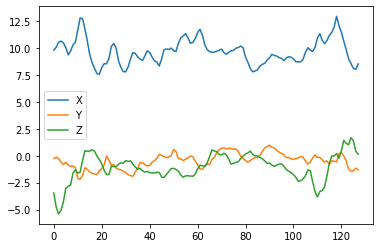

In [30]:
test[:128].plot()

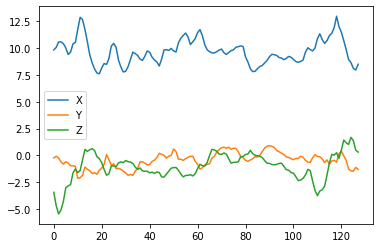

In [32]:
DA_Jitter(test[:128]).plot()

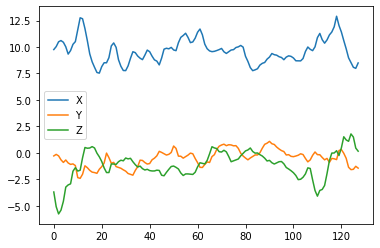

In [37]:
DA_Scaling(test[:128]).plot()

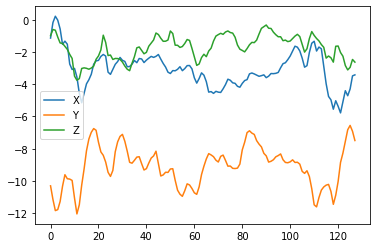

In [41]:
DA_Rotation(test[:128]).plot()

# Real-Time Data

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
col_DF = pd.read_csv('Test_DATASET/test_data.csv').columns
path = 'Real-time_augmented'

In [57]:
def mag_3_signals(x,y,z): # Euclidian magnitude
    return [math.sqrt((x[i]**2+y[i]**2+z[i]**2)) for i in range(len(x))]

def Processing(path, acc , gyro):
    col = ['X', 'Y', 'Z']
    
    base_acc = pd.read_csv('{0}/{1}'.format(path,acc))
    base_gryo = pd.read_csv('{0}/{1}'.format(path,gyro))
    
    acc_aug = DA_Jitter(base_acc)
    gryo_aug = DA_Jitter(base_gryo)
    
    base_acc = pd.concat([base_acc, acc_aug], axis = 0)
    base_gryo = pd.concat([base_gryo, gryo_aug], axis = 0)

    print(base_acc.shape, base_gryo.shape)
   

    last = pd.DataFrame(columns=col_DF)
    print(last.shape)

    n = base_acc.shape[0]//128 -1
    for i in range(n):
        gryo = base_gryo.iloc[i*128:(i+1) * 129 - i,:]
        acc = base_acc.iloc[i*128:(i+1) * 129 - i ,:]
        
        
#         for i in col:
#             acc[i] = acc.loc[:, i] / 9.8

        result = {}

        tBodyAcc, tGravityAcc, tBodyAccJerk, tBodyGyro, tBodyGyroJerk, \
        tBodyAccMag, tGravityAccMag,tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag, \
        fBodyAcc, fBodyAccJerk, fBodyGyro, \
        fBodyAccMag, fBodyAccJerkMag, fBodyGyroMag,fBodyGyroJerkMag = main(gryo,acc)


        result = collectFeatures(tBodyAcc, tGravityAcc, tBodyAccJerk, tBodyGyro, tBodyGyroJerk,
                                 tBodyAccMag, tGravityAccMag,tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag, 
                                 fBodyAcc, fBodyAccJerk, fBodyGyro, 
                                 fBodyAccMag, fBodyAccJerkMag, fBodyGyroMag,fBodyGyroJerkMag)
        result = pd.DataFrame(result, index=[0])
        
#         grav_acc_mag = mag_3_signals(tGravityAcc["X"], tGravityAcc['Y'], tGravityAcc['Z'])

#         print('mean value = '+str(np.array(grav_acc_mag).mean())[0:5]+ ' g')


        last = pd.concat([last, result], axis = 0)


    return last

# Walking

In [58]:
walking = Processing(path, 'walking_acc.csv','walking_gryo.csv')
walking.describe()

(11816, 3) (11816, 3)
(0, 561)


tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
count        91.000000        91.000000        91.000000       91.000000   
mean         -0.012321        -0.010904        -0.002244        0.339371   
std           0.074003         0.096486         0.027197        0.043143   
min          -0.185721        -0.298416        -0.063404        0.244607   
25%          -0.066932        -0.059095        -0.019720        0.304209   
50%          -0.026871        -0.007092        -0.003756        0.344759   
75%           0.035451         0.032013         0.015496        0.370501   
max           0.163316         0.332213         0.073852        0.436788   

       tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_mad_X  tBodyAcc_mad_Y  \
count       91.000000       91.000000       91.000000       91.000000   
mean         0.374656        0.143363        0.312255        0.278147   
std          0.073882        0.018071        0.059006        0.071156   
min          0.257396        0.110989        0.180032        0.157543   
25%          0.322588        0.131570        0.266310        0.234283   
50%          0.369769        0.141440        0.314837        0.266195   
75%          0.406841        0.153347        0.356459        0.308342   
max          0.586681        0.196599        0.451711        0.508833   

       tBodyAcc_mad_Z  tBodyAcc_max_X  tBodyAcc_max_Y  tBodyAcc_max_Z  \
count       91.000000       91.000000       91.000000       91.000000   
mean         0.142084        0.720698        1.138551        0.328659   
std          0.025336        0.187835        0.347124        0.084056   
min          0.088135        0.403030        0.476699        0.185932   
25%          0.123550        0.603957        0.952727        0.273633   
50%          0.143261        0.695009        1.130317        0.317574   
75%          0.159027        0.800924        1.326128        0.365037   
max          0.199404        1.207502        2.669438        0.715183   

       tBodyAcc_min_X  tBodyAcc_min_Y  tBodyAcc_min_Z  tBodyAcc_sma  \
count       91.000000       91.000000       91.000000     91.000000   
mean        -0.855970       -1.090292       -0.338188     28.458936   
std          0.145766        0.329712        0.062614      3.729349   
min         -1.209561       -2.217856       -0.532873     21.546504   
25%         -0.952806       -1.302544       -0.389423     25.709161   
50%         -0.844471       -1.002266       -0.334127     28.182707   
75%         -0.747707       -0.878726       -0.291247     30.780478   
max         -0.522905       -0.545399       -0.197037     39.968930   

       tBodyAcc_energy_X  tBodyAcc_energy_Y  tBodyAcc_energy_Z  \
count          91.000000          91.000000          91.000000   
mean           15.690411          19.851774           2.766393   
std             4.233530           9.862289           0.756663   
min             7.724920           8.585090           1.594658   
25%            12.225410          13.687826           2.279103   
50%            15.588251          18.216070           2.660290   
75%            18.323396          22.157212           3.120090   
max            27.807780          56.330668           5.645495   

       tBodyAcc_iqr_X  tBodyAcc_iqr_Y  tBodyAcc_iqr_Z  tBodyAcc_entropy_X  \
count       91.000000       91.000000       91.000000           91.000000   
mean         0.420016        0.376774        0.191105            4.542124   
std          0.079442        0.095807        0.035454            0.058179   
min          0.246041        0.216697        0.118225            4.404903   
25%          0.361839        0.315491        0.167650            4.508575   
50%          0.409859        0.362522        0.185738            4.538064   
75%          0.480855        0.417675        0.213938            4.576011   
max          0.633568        0.691055        0.279397            4.681459   

       tBodyAcc_entropy_Y  tBodyAcc_entropy_Z  tBodyAcc_X_1  tBodyAcc_X_2  \


In [59]:
walking_up1 = Processing(path, 'walking_up_acc1.csv','walking_up_gryo1.csv')
walking_up1.describe()

(4506, 3) (4506, 3)
(0, 561)


tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
count        34.000000        34.000000        34.000000       34.000000   
mean         -0.006626        -0.000447        -0.001862        0.217057   
std           0.045257         0.065190         0.019635        0.041023   
min          -0.109018        -0.157311        -0.053189        0.153390   
25%          -0.031689        -0.026953        -0.015958        0.197248   
50%          -0.010299        -0.003739        -0.000280        0.208421   
75%           0.013650         0.032365         0.010845        0.245525   
max           0.133956         0.160153         0.043215        0.318683   

       tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_mad_X  tBodyAcc_mad_Y  \
count       34.000000       34.000000       34.000000       34.000000   
mean         0.292881        0.109699        0.190639        0.273444   
std          0.055091        0.019373        0.041417        0.056651   
min          0.206152        0.076142        0.104359        0.156449   
25%          0.252689        0.096493        0.160064        0.242856   
50%          0.282793        0.109129        0.185421        0.273057   
75%          0.321198        0.123827        0.205412        0.303899   
max          0.441919        0.143399        0.279725        0.404037   

       tBodyAcc_mad_Z  tBodyAcc_max_X  tBodyAcc_max_Y  tBodyAcc_max_Z  \
count       34.000000       34.000000       34.000000       34.000000   
mean         0.102070        0.489520        0.721137        0.279633   
std          0.017954        0.144090        0.249399        0.094894   
min          0.069564        0.283034        0.441892        0.156924   
25%          0.089282        0.412211        0.550969        0.207426   
50%          0.098121        0.465502        0.673456        0.270334   
75%          0.111848        0.517696        0.801202        0.316694   
max          0.142265        0.953925        1.358415        0.553285   

       tBodyAcc_min_X  tBodyAcc_min_Y  tBodyAcc_min_Z  tBodyAcc_sma  \
count       34.000000       34.000000       34.000000     34.000000   
mean        -0.548826       -0.722028       -0.249866     20.918657   
std          0.142813        0.259033        0.068837      2.887220   
min         -0.928785       -1.463464       -0.388919     16.020194   
25%         -0.637681       -0.871955       -0.294611     18.842510   
50%         -0.531310       -0.627533       -0.250613     21.217541   
75%         -0.432325       -0.567652       -0.197268     22.924175   
max         -0.330475       -0.438371       -0.126418     26.411433   

       tBodyAcc_energy_X  tBodyAcc_energy_Y  tBodyAcc_energy_Z  \
count          34.000000          34.000000          34.000000   
mean            6.499723          11.884819           1.635310   
std             2.697424           4.941260           0.563921   
min             3.044345           5.724660           0.752455   
25%             5.029442           8.556217           1.202739   
50%             5.660169          10.783398           1.556091   
75%             7.857652          13.996515           1.971856   
max            14.520845          26.917369           2.690091   

       tBodyAcc_iqr_X  tBodyAcc_iqr_Y  tBodyAcc_iqr_Z  tBodyAcc_entropy_X  \
count       34.000000       34.000000       34.000000           34.000000   
mean         0.255880        0.373042        0.138270            4.526778   
std          0.059154        0.074638        0.024296            0.049900   
min          0.136746        0.218329        0.096377            4.417213   
25%          0.212684        0.331180        0.120752            4.501515   
50%          0.251120        0.368987        0.137175            4.526706   
75%          0.286012        0.412907        0.150028            4.562074   
max          0.388499        0.544746        0.192909            4.609268   

       tBodyAcc_entropy_Y  tBodyAcc_entropy_Z  tBodyAcc_X_1  tBodyAcc_X_2  \


In [60]:
walking_up2 = Processing(path, 'walking_up_acc2.csv','walking_up_gryo2.csv')
walking_up2.describe()

(4506, 3) (4506, 3)
(0, 561)


tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
count        34.000000        34.000000        34.000000       34.000000   
mean         -0.007357         0.001865        -0.008724        0.241214   
std           0.043852         0.054848         0.029283        0.055059   
min          -0.084736        -0.093307        -0.073623        0.143633   
25%          -0.041516        -0.040959        -0.025145        0.202264   
50%          -0.008373         0.011453        -0.005908        0.237277   
75%           0.008498         0.044124         0.010190        0.272826   
max           0.091856         0.093505         0.046264        0.375961   

       tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_mad_X  tBodyAcc_mad_Y  \
count       34.000000       34.000000       34.000000       34.000000   
mean         0.321230        0.124511        0.235690        0.306625   
std          0.048696        0.022290        0.063240        0.056670   
min          0.220999        0.076215        0.122991        0.209437   
25%          0.286314        0.107620        0.188583        0.265947   
50%          0.317923        0.122625        0.241290        0.306178   
75%          0.362124        0.143563        0.279701        0.340635   
max          0.422115        0.167864        0.414695        0.421319   

       tBodyAcc_mad_Z  tBodyAcc_max_X  tBodyAcc_max_Y  tBodyAcc_max_Z  \
count       34.000000       34.000000       34.000000       34.000000   
mean         0.118122        0.521964        0.664965        0.333514   
std          0.025617        0.137073        0.149300        0.083970   
min          0.077798        0.251470        0.362832        0.174838   
25%          0.098810        0.426036        0.566532        0.289958   
50%          0.117311        0.493641        0.653956        0.329311   
75%          0.134659        0.591971        0.789875        0.388820   
max          0.180036        0.891698        0.925242        0.528426   

       tBodyAcc_min_X  tBodyAcc_min_Y  tBodyAcc_min_Z  tBodyAcc_sma  \
count       34.000000       34.000000       34.000000     34.000000   
mean        -0.557600       -0.872525       -0.285393     23.717856   
std          0.180370        0.260292        0.081369      3.290197   
min         -1.013829       -1.569406       -0.487597     17.957870   
25%         -0.617650       -0.973559       -0.337519     21.207968   
50%         -0.548076       -0.785648       -0.275268     23.794196   
75%         -0.444104       -0.743621       -0.224625     25.831573   
max         -0.270759       -0.517499       -0.168963     29.263119   

       tBodyAcc_energy_X  tBodyAcc_energy_Y  tBodyAcc_energy_Z  \
count          34.000000          34.000000          34.000000   
mean            8.070020          13.876903           2.162385   
std             3.632853           4.054181           0.812709   
min             2.646584           6.254636           0.743536   
25%             5.317911          10.699536           1.518157   
50%             7.242553          13.407608           1.945345   
75%             9.818070          17.151705           2.754830   
max            18.472416          22.848775           3.972449   

       tBodyAcc_iqr_X  tBodyAcc_iqr_Y  tBodyAcc_iqr_Z  tBodyAcc_entropy_X  \
count       34.000000       34.000000       34.000000           34.000000   
mean         0.326404        0.424193        0.159820            4.567556   
std          0.088094        0.080828        0.032964            0.065487   
min          0.144091        0.296133        0.103127            4.339760   
25%          0.260390        0.365814        0.139339            4.539514   
50%          0.339297        0.407289        0.159550            4.583607   
75%          0.383768        0.470793        0.181668            4.610202   
max          0.567318        0.579911        0.241538            4.645906   

       tBodyAcc_entropy_Y  tBodyAcc_entropy_Z  tBodyAcc_X_1  tBodyAcc_X_2  \


In [61]:
walking_up3 = Processing(path, 'walking_up_acc3.csv','walking_up_gryo3.csv')
walking_up3.describe()

(4510, 3) (4508, 3)
(0, 561)


tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
count        34.000000        34.000000        34.000000       34.000000   
mean          0.013800        -0.005785         0.010099        0.282310   
std           0.050406         0.061115         0.022504        0.056439   
min          -0.077950        -0.142434        -0.049303        0.181238   
25%          -0.019330        -0.042802        -0.000060        0.247644   
50%           0.016991        -0.006716         0.012082        0.274732   
75%           0.044719         0.044847         0.023806        0.322502   
max           0.148527         0.115283         0.053622        0.395912   

       tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_mad_X  tBodyAcc_mad_Y  \
count       34.000000       34.000000       34.000000       34.000000   
mean         0.315509        0.132300        0.251482        0.310150   
std          0.036880        0.020707        0.065044        0.053987   
min          0.231391        0.097513        0.156389        0.181603   
25%          0.294130        0.116314        0.199777        0.273018   
50%          0.318544        0.129113        0.236759        0.319690   
75%          0.340917        0.141673        0.300019        0.347076   
max          0.389105        0.184168        0.382124        0.401286   

       tBodyAcc_mad_Z  tBodyAcc_max_X  tBodyAcc_max_Y  tBodyAcc_max_Z  \
count       34.000000       34.000000       34.000000       34.000000   
mean         0.121580        0.641935        0.665930        0.360559   
std          0.024929        0.182258        0.133705        0.081528   
min          0.075718        0.331122        0.383685        0.255990   
25%          0.102526        0.485783        0.580894        0.300855   
50%          0.121214        0.645351        0.659526        0.338811   
75%          0.138508        0.745476        0.746746        0.396314   
max          0.169777        1.135611        0.972561        0.625527   

       tBodyAcc_min_X  tBodyAcc_min_Y  tBodyAcc_min_Z  tBodyAcc_sma  \
count       34.000000       34.000000       34.000000     34.000000   
mean        -0.693112       -0.746579       -0.277780     25.085776   
std          0.165643        0.152926        0.060983      2.961262   
min         -0.965423       -1.159225       -0.429721     19.669324   
25%         -0.820330       -0.826177       -0.314716     22.837790   
50%         -0.730075       -0.752310       -0.271976     25.303884   
75%         -0.560015       -0.619628       -0.223423     27.134255   
max         -0.394550       -0.477920       -0.172913     31.560223   

       tBodyAcc_energy_X  tBodyAcc_energy_Y  tBodyAcc_energy_Z  \
count          34.000000          34.000000          34.000000   
mean           10.937199          13.379156           2.369662   
std             4.249411           3.204109           0.804195   
min             4.265089           6.921605           1.227935   
25%             7.980643          11.690514           1.771823   
50%            10.016053          13.300545           2.248001   
75%            13.784222          14.980067           2.689784   
max            20.589651          21.976363           4.696625   

       tBodyAcc_iqr_X  tBodyAcc_iqr_Y  tBodyAcc_iqr_Z  tBodyAcc_entropy_X  \
count       34.000000       34.000000       34.000000           34.000000   
mean         0.349661        0.421049        0.165252            4.537506   
std          0.097398        0.067484        0.036300            0.053049   
min          0.227892        0.260838        0.100156            4.394863   
25%          0.274621        0.379924        0.135685            4.513057   
50%          0.330517        0.425103        0.162288            4.548883   
75%          0.408319        0.468076        0.188329            4.574190   
max          0.565060        0.556248        0.227428            4.611105   

       tBodyAcc_entropy_Y  tBodyAcc_entropy_Z  tBodyAcc_X_1  tBodyAcc_X_2  \


In [62]:
walking_down1 = Processing(path, 'walking_down_acc1.csv','walking_down_gryo1.csv')
walking_down1.describe()

(3382, 3) (3382, 3)
(0, 561)


tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
count        25.000000        25.000000        25.000000       25.000000   
mean          0.011423        -0.001415         0.008983        0.248745   
std           0.055689         0.100586         0.016899        0.032629   
min          -0.132503        -0.242933        -0.020783        0.192829   
25%          -0.019549        -0.061512        -0.003040        0.225564   
50%           0.017597         0.009614         0.004342        0.248072   
75%           0.047443         0.053912         0.015593        0.271272   
max           0.158861         0.205160         0.045451        0.301928   

       tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_mad_X  tBodyAcc_mad_Y  \
count       25.000000       25.000000       25.000000       25.000000   
mean         0.398717        0.126738        0.244556        0.336924   
std          0.067252        0.019527        0.034621        0.059749   
min          0.269766        0.097624        0.163625        0.232510   
25%          0.348387        0.110926        0.225605        0.304641   
50%          0.402663        0.133001        0.241591        0.332231   
75%          0.456636        0.141463        0.264931        0.380025   
max          0.506421        0.159273        0.311176        0.504725   

       tBodyAcc_mad_Z  tBodyAcc_max_X  tBodyAcc_max_Y  tBodyAcc_max_Z  \
count       25.000000       25.000000       25.000000       25.000000   
mean         0.120655        0.603635        1.003367        0.293609   
std          0.024528        0.129851        0.371421        0.073845   
min          0.081635        0.389159        0.556087        0.181126   
25%          0.097483        0.495432        0.676521        0.230678   
50%          0.122972        0.610607        0.985450        0.291690   
75%          0.144391        0.705584        1.169975        0.330971   
max          0.164197        0.821480        2.195726        0.464933   

       tBodyAcc_min_X  tBodyAcc_min_Y  tBodyAcc_min_Z  tBodyAcc_sma  \
count       25.000000       25.000000       25.000000     25.000000   
mean        -0.561207       -1.094202       -0.315385     26.194181   
std          0.159508        0.348262        0.073360      2.698373   
min         -1.122335       -1.808640       -0.471480     21.647213   
25%         -0.605180       -1.374286       -0.359337     23.954880   
50%         -0.521121       -1.061499       -0.330351     26.405801   
75%         -0.477556       -0.828889       -0.263443     27.980107   
max         -0.368604       -0.557484       -0.177391     31.993528   

       tBodyAcc_energy_X  tBodyAcc_energy_Y  tBodyAcc_energy_Z  \
count          25.000000          25.000000          25.000000   
mean            8.448494          22.148097           2.148275   
std             2.538113           7.586444           0.651077   
min             4.767133           9.770166           1.223697   
25%             6.872766          16.021033           1.591474   
50%             8.165167          21.199141           2.295476   
75%             9.647377          27.839445           2.597453   
max            14.898860          38.214806           3.360321   

       tBodyAcc_iqr_X  tBodyAcc_iqr_Y  tBodyAcc_iqr_Z  tBodyAcc_entropy_X  \
count       25.000000       25.000000       25.000000           25.000000   
mean         0.331426        0.467043        0.163361            4.566637   
std          0.047899        0.081867        0.034255            0.046588   
min          0.227652        0.314344        0.113715            4.452630   
25%          0.308155        0.414261        0.129320            4.521423   
50%          0.332229        0.460640        0.167745            4.583676   
75%          0.355306        0.492580        0.197028            4.598377   
max          0.440552        0.666437        0.224414            4.634293   

       tBodyAcc_entropy_Y  tBodyAcc_entropy_Z  tBodyAcc_X_1  tBodyAcc_X_2  \


In [63]:
walking_down2 = Processing(path, 'walking_down_acc2.csv','walking_down_gryo2.csv')
walking_down2.describe()

(3384, 3) (3380, 3)
(0, 561)


tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
count        25.000000        25.000000        25.000000       25.000000   
mean         -0.010669        -0.010766        -0.003511        0.261102   
std           0.072490         0.071974         0.022689        0.042481   
min          -0.177992        -0.145343        -0.045330        0.180443   
25%          -0.048018        -0.041536        -0.022831        0.235175   
50%          -0.013846        -0.023719         0.000345        0.254783   
75%           0.017096         0.019559         0.015215        0.289446   
max           0.164005         0.132040         0.032631        0.380390   

       tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_mad_X  tBodyAcc_mad_Y  \
count       25.000000       25.000000       25.000000       25.000000   
mean         0.426091        0.131941        0.241142        0.293272   
std          0.180574        0.048719        0.049328        0.068761   
min          0.302984        0.087912        0.161546        0.196536   
25%          0.360498        0.107920        0.195895        0.248950   
50%          0.383378        0.120425        0.247763        0.286838   
75%          0.417141        0.139124        0.273068        0.315864   
max          1.242391        0.342291        0.330463        0.448018   

       tBodyAcc_mad_Z  tBodyAcc_max_X  tBodyAcc_max_Y  tBodyAcc_max_Z  \
count       25.000000       25.000000       25.000000       25.000000   
mean         0.121258        0.560609        1.130083        0.334904   
std          0.026720        0.173132        0.897974        0.333353   
min          0.077045        0.313057        0.677404        0.121392   
25%          0.102268        0.461336        0.736091        0.207964   
50%          0.119528        0.503388        0.986739        0.277691   
75%          0.134387        0.632457        1.110177        0.338946   
max          0.172692        1.058212        5.304929        1.896254   

       tBodyAcc_min_X  tBodyAcc_min_Y  tBodyAcc_min_Z  tBodyAcc_sma  \
count       25.000000       25.000000       25.000000     25.000000   
mean        -0.659770       -1.354577       -0.354169     26.427278   
std          0.196155        0.815805        0.228600      4.694510   
min         -1.343843       -4.731578       -1.393746     21.643144   
25%         -0.712651       -1.440726       -0.347650     23.331024   
50%         -0.648788       -1.201895       -0.297962     25.849504   
75%         -0.529460       -0.858813       -0.267762     27.802331   
max         -0.409185       -0.685765       -0.220377     44.102075   

       tBodyAcc_energy_X  tBodyAcc_energy_Y  tBodyAcc_energy_Z  \
count          25.000000          25.000000          25.000000   
mean            9.608359          27.896940           2.584793   
std             3.894691          36.015226           2.688818   
min             4.171510          11.876799           1.003577   
25%             7.385004          16.661538           1.529824   
50%             8.664114          19.491097           1.899607   
75%            11.947801          23.254681           2.571283   
max            22.576298         197.644485          15.008531   

       tBodyAcc_iqr_X  tBodyAcc_iqr_Y  tBodyAcc_iqr_Z  tBodyAcc_entropy_X  \
count       25.000000       25.000000       25.000000           25.000000   
mean         0.332215        0.409937        0.166255            4.562160   
std          0.067616        0.101074        0.038179            0.058517   
min          0.232301        0.251462        0.104961            4.414633   
25%          0.276764        0.346743        0.141777            4.528987   
50%          0.322195        0.391920        0.164101            4.570947   
75%          0.369988        0.468034        0.188923            4.608640   
max          0.488376        0.604293        0.245648            4.658071   

       tBodyAcc_entropy_Y  tBodyAcc_entropy_Z  tBodyAcc_X_1  tBodyAcc_X_2  \


In [64]:
walking_down3 = Processing(path, 'walking_down_acc3.csv','walking_down_gryo3.csv')
walking_down3.describe()

(3378, 3) (3378, 3)
(0, 561)


tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
count        25.000000        25.000000        25.000000       25.000000   
mean         -0.000378        -0.019261        -0.004023        0.272431   
std           0.053681         0.082189         0.031812        0.041190   
min          -0.101309        -0.167205        -0.102066        0.181544   
25%          -0.045023        -0.072885        -0.029839        0.248513   
50%          -0.010248        -0.018406         0.001022        0.275144   
75%           0.027695         0.022581         0.016666        0.294678   
max           0.107663         0.223304         0.049271        0.359370   

       tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_mad_X  tBodyAcc_mad_Y  \
count       25.000000       25.000000       25.000000       25.000000   
mean         0.463668        0.145368        0.254251        0.375598   
std          0.091945        0.023088        0.050560        0.085325   
min          0.302424        0.102890        0.174680        0.206929   
25%          0.394774        0.129832        0.208101        0.316850   
50%          0.463415        0.144170        0.261188        0.353070   
75%          0.518395        0.161216        0.283015        0.428104   
max          0.627906        0.196993        0.336907        0.562231   

       tBodyAcc_mad_Z  tBodyAcc_max_X  tBodyAcc_max_Y  tBodyAcc_max_Z  \
count       25.000000       25.000000       25.000000       25.000000   
mean         0.134968        0.643528        1.041727        0.336785   
std          0.025314        0.137117        0.242930        0.087521   
min          0.099892        0.330754        0.684718        0.223788   
25%          0.117382        0.578478        0.888806        0.289506   
50%          0.127442        0.642148        0.987792        0.317656   
75%          0.142584        0.713610        1.106069        0.370567   
max          0.184084        0.936979        1.590677        0.639779   

       tBodyAcc_min_X  tBodyAcc_min_Y  tBodyAcc_min_Z  tBodyAcc_sma  \
count       25.000000       25.000000       25.000000     25.000000   
mean        -0.670221       -1.404864       -0.384896     29.244655   
std          0.181955        0.502289        0.127331      4.144533   
min         -1.047186       -2.757400       -0.623537     22.579485   
25%         -0.771526       -1.555545       -0.511454     26.315682   
50%         -0.676367       -1.317102       -0.350069     28.697977   
75%         -0.552211       -1.131181       -0.284169     32.420403   
max         -0.370202       -0.648545       -0.169369     36.893195   

       tBodyAcc_energy_X  tBodyAcc_energy_Y  tBodyAcc_energy_Z  \
count          25.000000          25.000000          25.000000   
mean           10.062614          29.434838           2.896807   
std             3.187219          11.522343           1.043838   
min             4.567679          11.966889           1.430849   
25%             8.006574          21.433745           2.193776   
50%             9.763366          28.916838           2.775593   
75%            11.749134          34.536835           3.409755   
max            17.871416          51.488123           6.300611   

       tBodyAcc_iqr_X  tBodyAcc_iqr_Y  tBodyAcc_iqr_Z  tBodyAcc_entropy_X  \
count       25.000000       25.000000       25.000000           25.000000   
mean         0.344655        0.507752        0.185456            4.547627   
std          0.062430        0.105036        0.036059            0.056870   
min          0.245733        0.277570        0.138817            4.423759   
25%          0.300362        0.446038        0.163171            4.514185   
50%          0.339980        0.507030        0.174587            4.562240   
75%          0.387545        0.582474        0.186980            4.597211   
max          0.446963        0.725563        0.272775            4.619593   

       tBodyAcc_entropy_Y  tBodyAcc_entropy_Z  tBodyAcc_X_1  tBodyAcc_X_2  \


In [65]:
sitting = Processing(path, 'sitting_acc.csv','sitting_gryo.csv')
sitting.describe()

(11868, 3) (11864, 3)
(0, 561)


tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
count        91.000000        91.000000        91.000000       91.000000   
mean          0.000177        -0.000405        -0.000671        0.019192   
std           0.003919         0.006658         0.004087        0.012347   
min          -0.013581        -0.017949        -0.011992        0.003754   
25%          -0.001248        -0.003449        -0.001958        0.006307   
50%           0.000579        -0.000239        -0.000302        0.020171   
75%           0.001914         0.002634         0.000555        0.030822   
max           0.009912         0.033455         0.012627        0.038259   

       tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_mad_X  tBodyAcc_mad_Y  \
count       91.000000       91.000000       91.000000       91.000000   
mean         0.030646        0.017947        0.017678        0.027488   
std          0.018212        0.014283        0.012077        0.016013   
min          0.007029        0.001789        0.002961        0.006062   
25%          0.013882        0.003002        0.005710        0.011450   
50%          0.029885        0.017367        0.016050        0.028123   
75%          0.038191        0.030872        0.029104        0.035569   
max          0.092451        0.039566        0.039350        0.072876   

       tBodyAcc_mad_Z  tBodyAcc_max_X  tBodyAcc_max_Y  tBodyAcc_max_Z  \
count       91.000000       91.000000       91.000000       91.000000   
mean         0.016738        0.050959        0.077269        0.045737   
std          0.013978        0.032489        0.051925        0.038631   
min          0.001600        0.007082        0.015559        0.003573   
25%          0.002830        0.017277        0.030643        0.007379   
50%          0.013059        0.056417        0.074511        0.038604   
75%          0.029633        0.080238        0.098544        0.083325   
max          0.039776        0.112942        0.261550        0.110788   

       tBodyAcc_min_X  tBodyAcc_min_Y  tBodyAcc_min_Z  tBodyAcc_sma  \
count       91.000000       91.000000       91.000000     91.000000   
mean        -0.049350       -0.085742       -0.048724      2.271767   
std          0.034270        0.064981        0.038145      1.365193   
min         -0.112490       -0.365034       -0.112346      0.460435   
25%         -0.079058       -0.101424       -0.082256      0.752237   
50%         -0.060068       -0.074292       -0.044175      2.888630   
75%         -0.013064       -0.038166       -0.008759      3.299849   
max         -0.005087       -0.016868       -0.002883      5.295123   

       tBodyAcc_energy_X  tBodyAcc_energy_Y  tBodyAcc_energy_Z  \
count          91.000000          91.000000          91.000000   
mean            0.068396           0.167839           0.069223   
std             0.062552           0.200532           0.070133   
min             0.001887           0.006808           0.000423   
25%             0.005479           0.026524           0.001304   
50%             0.057316           0.121008           0.042100   
75%             0.125301           0.190808           0.124744   
max             0.199939           1.131575           0.209852   

       tBodyAcc_iqr_X  tBodyAcc_iqr_Y  tBodyAcc_iqr_Z  tBodyAcc_entropy_X  \
count       91.000000       91.000000       91.000000           91.000000   
mean         0.024049        0.037422        0.022468            4.530017   
std          0.016362        0.021762        0.018621            0.079625   
min          0.003910        0.008171        0.002246            4.022935   
25%          0.007608        0.015336        0.003850            4.497021   
50%          0.021983        0.038424        0.017591            4.542973   
75%          0.039466        0.047503        0.039357            4.575147   
max          0.052859        0.097118        0.053793            4.636836   

       tBodyAcc_entropy_Y  tBodyAcc_entropy_Z  tBodyAcc_X_1  tBodyAcc_X_2  \


In [66]:
staying = Processing(path, 'staying_acc.csv','staying_gryo.csv')
staying.describe()

(11856, 3) (11856, 3)
(0, 561)


tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
count        91.000000        91.000000        91.000000       91.000000   
mean          0.000811         0.000420        -0.000197        0.026169   
std           0.004991         0.006414         0.004157        0.012428   
min          -0.013877        -0.025608        -0.014679        0.007763   
25%          -0.001881        -0.003041        -0.001705        0.014267   
50%           0.000467         0.000812        -0.000427        0.030293   
75%           0.003168         0.002969         0.001118        0.035081   
max           0.018468         0.019755         0.011786        0.053640   

       tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_mad_X  tBodyAcc_mad_Y  \
count       91.000000       91.000000       91.000000       91.000000   
mean         0.026801        0.018720        0.024931        0.025129   
std          0.010932        0.013881        0.012099        0.011323   
min          0.009536        0.002394        0.006745        0.008872   
25%          0.015936        0.004544        0.013831        0.014500   
50%          0.029066        0.019170        0.025084        0.025109   
75%          0.035677        0.031660        0.035265        0.033786   
max          0.047217        0.042991        0.054252        0.051823   

       tBodyAcc_mad_Z  tBodyAcc_max_X  tBodyAcc_max_Y  tBodyAcc_max_Z  \
count       91.000000       91.000000       91.000000       91.000000   
mean         0.017823        0.064958        0.070143        0.048397   
std          0.013760        0.035673        0.031057        0.038101   
min          0.002090        0.016477        0.026949        0.004456   
25%          0.004092        0.031925        0.042527        0.009962   
50%          0.019123        0.068378        0.068177        0.045927   
75%          0.030179        0.086952        0.090748        0.083021   
max          0.047169        0.174419        0.154554        0.133784   

       tBodyAcc_min_X  tBodyAcc_min_Y  tBodyAcc_min_Z  tBodyAcc_sma  \
count       91.000000       91.000000       91.000000     91.000000   
mean        -0.065621       -0.069300       -0.047157      2.444864   
std          0.032693        0.032183        0.035555      1.226805   
min         -0.155414       -0.182886       -0.125439      0.688010   
25%         -0.087474       -0.088756       -0.078645      1.174086   
50%         -0.062427       -0.064179       -0.040075      2.927557   
75%         -0.038221       -0.043901       -0.011953      3.434167   
max         -0.016979       -0.023235       -0.005528      4.813715   

       tBodyAcc_energy_X  tBodyAcc_energy_Y  tBodyAcc_energy_Z  \
count          91.000000          91.000000          91.000000   
mean            0.110449           0.112302           0.071442   
std             0.091524           0.083438           0.072190   
min             0.007968           0.013027           0.000743   
25%             0.028685           0.032984           0.002954   
50%             0.119982           0.108591           0.047263   
75%             0.161500           0.169894           0.131108   
max             0.369507           0.369313           0.262413   

       tBodyAcc_iqr_X  tBodyAcc_iqr_Y  tBodyAcc_iqr_Z  tBodyAcc_entropy_X  \
count       91.000000       91.000000       91.000000           91.000000   
mean         0.033823        0.034043        0.024126            4.552877   
std          0.016608        0.015352        0.018767            0.054906   
min          0.008343        0.012639        0.002717            4.370305   
25%          0.017983        0.019464        0.005684            4.523096   
50%          0.034355        0.034160        0.024270            4.557847   
75%          0.047134        0.046474        0.041826            4.587632   
max          0.073333        0.071389        0.065656            4.667127   

       tBodyAcc_entropy_Y  tBodyAcc_entropy_Z  tBodyAcc_X_1  tBodyAcc_X_2  \


In [67]:
lying = Processing(path, 'lying_acc.csv','lying_gryo.csv')
lying.describe()

(11872, 3) (11872, 3)
(0, 561)


tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
count        91.000000        91.000000        91.000000       91.000000   
mean          0.000838         0.000365        -0.000296        0.016646   
std           0.003547         0.004398         0.003839        0.015041   
min          -0.011157        -0.015835        -0.013716        0.001415   
25%          -0.000065        -0.001139        -0.000912        0.001803   
50%           0.000517         0.000811        -0.000136        0.010105   
75%           0.001269         0.001799         0.000718        0.031446   
max           0.014803         0.016313         0.013771        0.037555   

       tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_mad_X  tBodyAcc_mad_Y  \
count       91.000000       91.000000       91.000000       91.000000   
mean         0.020287        0.017468        0.015789        0.019135   
std          0.014938        0.014905        0.014693        0.013804   
min          0.003059        0.000757        0.001254        0.002642   
25%          0.005506        0.001730        0.001770        0.005345   
50%          0.026021        0.023404        0.003019        0.023556   
75%          0.031969        0.032172        0.030152        0.030610   
max          0.063281        0.038636        0.040491        0.052545   

       tBodyAcc_mad_Z  tBodyAcc_max_X  tBodyAcc_max_Y  tBodyAcc_max_Z  \
count       91.000000       91.000000       91.000000       91.000000   
mean         0.016547        0.044460        0.053063        0.045522   
std          0.015094        0.040728        0.037933        0.040545   
min          0.000763        0.003119        0.005981        0.001466   
25%          0.001295        0.005427        0.014651        0.004988   
50%          0.010923        0.060176        0.059384        0.050751   
75%          0.031453        0.077682        0.084464        0.080928   
max          0.042149        0.135062        0.143009        0.130246   

       tBodyAcc_min_X  tBodyAcc_min_Y  tBodyAcc_min_Z  tBodyAcc_sma  \
count       91.000000       91.000000       91.000000     91.000000   
mean        -0.041541       -0.054284       -0.046491      1.842566   
std          0.038986        0.052866        0.039196      1.472693   
min         -0.116723       -0.323391       -0.129010      0.200882   
25%         -0.076840       -0.082056       -0.079891      0.302177   
50%         -0.016141       -0.060012       -0.059514      2.808573   
75%         -0.004097       -0.013132       -0.005678      3.278522   
max         -0.002176       -0.005561       -0.001866      3.832934   

       tBodyAcc_energy_X  tBodyAcc_energy_Y  tBodyAcc_energy_Z  \
count          91.000000          91.000000          91.000000   
mean            0.065788           0.083394           0.069054   
std             0.069055           0.096968           0.069187   
min             0.000264           0.001322           0.000073   
25%             0.000456           0.004148           0.000421   
50%             0.013499           0.087623           0.072297   
75%             0.128858           0.132312           0.136083   
max             0.208577           0.515826           0.192756   

       tBodyAcc_iqr_X  tBodyAcc_iqr_Y  tBodyAcc_iqr_Z  tBodyAcc_entropy_X  \
count       91.000000       91.000000       91.000000           91.000000   
mean         0.021238        0.025556        0.022326            4.542017   
std          0.019665        0.018488        0.020308            0.089987   
min          0.001754        0.003520        0.001070            3.884974   
25%          0.002331        0.007043        0.001765            4.520919   
50%          0.003987        0.031077        0.014931            4.559216   
75%          0.040642        0.040502        0.042308            4.577372   
max          0.053739        0.072708        0.057391            4.650039   

       tBodyAcc_entropy_Y  tBodyAcc_entropy_Z  tBodyAcc_X_1  tBodyAcc_X_2  \


In [68]:
walking_up = pd.concat([walking_up1,walking_up2,walking_up3],axis = 0)
walking_down = pd.concat([walking_down1, walking_down2, walking_down3],axis = 0)

In [69]:
X = pd.concat([walking, walking_up, walking_down, sitting, staying, lying],axis = 0)

In [70]:
w = [1 for _ in range(walking.shape[0]) ]
up = [2 for _ in range(walking_up.shape[0]) ]
down = [3 for _ in range(walking_down.shape[0]) ]
sit = [4 for _ in range(sitting.shape[0]) ]
s = [5 for _ in range(staying.shape[0]) ]
lay = [6 for _ in range(lying.shape[0]) ]


Y =  w + up + down + sit + s + lay 
Y = pd.DataFrame(data = Y,columns=['Label'])

In [71]:
X.to_csv('{0}/X.csv'.format(path), index = None)
Y.to_csv('{0}/y.csv'.format(path), index = None)

In [29]:
walking_up

tBodyAcc_mean_X  tBodyAcc_mean_Y  tBodyAcc_mean_Z  tBodyAcc_std_X  \
0        -0.013537        -0.009597        -0.008877        0.235351   
0        -0.031212        -0.123146        -0.016841        0.173826   
0        -0.063475         0.075075        -0.021226        0.238241   
0         0.004330         0.042005         0.017302        0.199732   
0        -0.055015        -0.000430         0.015131        0.272541   
0        -0.010344         0.024015        -0.006075        0.247954   
0         0.024931        -0.007048         0.010362        0.197145   
0         0.017374         0.025338         0.006645        0.178073   
0        -0.034084        -0.021666        -0.039356        0.156735   
0        -0.048629         0.096381         0.011007        0.261649   
0        -0.072294        -0.028669        -0.006148        0.279352   
0         0.012257        -0.047172         0.008997        0.206542   
0        -0.004639        -0.014722        -0.019719        0.154151   
0         0.023585        -0.031674         0.012321        0.210852   
0         0.069604        -0.122473         0.043215        0.220211   
0        -0.010254         0.008410        -0.013211        0.212907   
0        -0.007550        -0.033770        -0.015066        0.184464   
0        -0.022350         0.049866         0.014095        0.197714   
0        -0.010986         0.027641         0.000203        0.191514   
0         0.089368         0.018020         0.034384        0.240283   
0        -0.057319        -0.041843        -0.031758        0.223817   
0         0.006881         0.079812         0.000310        0.194299   
0        -0.024603         0.062801        -0.007352        0.246020   
0        -0.045962         0.032616        -0.004922        0.159473   
0         0.006816        -0.065675        -0.006894        0.236483   
0         0.002890        -0.082931        -0.010570        0.233264   
0        -0.022727         0.093505        -0.011613        0.238070   
0        -0.054488         0.051222         0.015527        0.375961   
0         0.009037        -0.034332         0.002488        0.298404   
0         0.057126         0.079814         0.043896        0.260654   
0        -0.072364        -0.029841         0.012757        0.219463   
0        -0.021647        -0.043385        -0.000055        0.308018   
0         0.070598        -0.054844         0.035335        0.300715   
0         0.089301        -0.032741         0.009338        0.269179   
0        -0.014209        -0.018304        -0.026090        0.271203   
0         0.026893         0.053214         0.009557        0.278261   
0         0.035427         0.090208         0.009191        0.244196   
0         0.047197         0.115283         0.025440        0.262977   
0         0.021765         0.055656         0.018172        0.181238   
0         0.040960         0.070336         0.011761        0.255357   
0        -0.019793         0.060743        -0.000874        0.285704   
0        -0.032941         0.056156        -0.000310        0.315847   
0         0.022863         0.004943         0.034542        0.341520   
0        -0.002562        -0.019113         0.000690        0.330119   
0         0.043525         0.067922         0.013490        0.392645   
0        -0.025558         0.044853        -0.049303        0.338041   
0         0.020995        -0.077250         0.005200        0.247038   
0        -0.003380        -0.121340         0.013142        0.279887   

   tBodyAcc_std_Y  tBodyAcc_std_Z  tBodyAcc_mad_X  tBodyAcc_mad_Y  \
0        0.236939        0.136876        0.172868        0.188029   
0        0.299704        0.092666        0.179592        0.281198   
0        0.282621        0.097135        0.205532        0.274248   
0        0.267036        0.100200        0.158349        0.274592   
0        0.252863        0.119834        0.279725        0.305321   
0        0.419577        0.143399        0.237629        0.3